In [1]:
import sys
sys.path.append(r"C:\Users\shrey")

In [2]:
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LogisticRegression

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import EstimatorV2 as AEREstimator
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, EstimatorOptions

from adaptive_error_mitigation.analytics import (
    extract_backend_metrics,
    analyze_qubit_idling,
)
from adaptive_error_mitigation.utils import cal_em_eff_estimator
from adaptive_error_mitigation.benchmarking import dd_benchmark_circuit

In [3]:
service = QiskitRuntimeService(name = 'Reserach_IITJ')
Backend_list = service.backends()

management.get:WARNING:2026-01-08 13:09:04,876: Loading saved account: Reserach_IITJ


In [4]:
estimator_options = EstimatorOptions(
    dynamical_decoupling={"enable": False},
    twirling={"enable_gates": False, "enable_measure": False},
    resilience_level=0,
    max_execution_time=50,
)

In [42]:
QUBITS = [7, 10, 13, 16, 19, 22, 25, 28, 31]
QUBITS.reverse()
df = pd.DataFrame(columns=["num_qubits", "max_decoher_err_prob", "evs_ideal", "evs_nodd", "evs_dd", "error_nodd", "error_dd", "error_improvement_percent"])
estimator = Estimator(mode=backend, options=estimator_options)

for num_qubit, job in zip(QUBITS, service.jobs(limit = 9)):
    isa_qc, dd_circ_measured, isa_observable = dd_benchmark_circuit(num_qubit, backend)
    
    idling_analysis = analyze_qubit_idling(isa_qc, backend)
    max_decoher_err_prob = idling_analysis["max_ratio_qubit"]["decoher_err_prob"]

    aerEstimator = AEREstimator()
    evs_ideal = aerEstimator.run([(dd_circ_measured, isa_observable)]).result()[0].data.evs
    
    result = job.result()
    evs_nodd_ibmtorino = result[0].data.evs
    evs_dd_xx_ibmtorino = result[1].data.evs

    results = cal_em_eff_estimator(evs_nodd_ibmtorino, evs_dd_xx_ibmtorino, evs_ideal)

    row = pd.DataFrame({
        "num_qubits" : [num_qubit],
        "max_decoher_err_prob" : [max_decoher_err_prob],
        "evs_ideal" : [evs_ideal],
        "evs_nodd" : [results['EVS_nodd']],
        "evs_dd" : [results['EVS_dd']],
        "error_nodd" : [results['ERROR_nodd']],
        "error_dd" : [results['ERROR_dd']],
        "error_improvement_percent" : [results["ERROR_reduction_percent"]]
    })
    df = pd.concat([df, row], ignore_index=True)

X = df[["max_decoher_err_prob"]].values  # shape (n_samples, 1)
y = (df["error_improvement_percent"] > 0).astype(int)  # shape (n_samples,)
clf = LogisticRegression().fit(X, y)
p = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
probs = clf.predict_proba(p)[:,1]
threshold_ml = p[np.argmin(np.abs(probs - 0.5))][0]

C:\Users\shrey\AppData\Local\Temp\ipykernel_3924\2798715998.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row], ignore_index=True)


In [43]:
df

,num_qubits,max_decoher_err_prob,evs_ideal,evs_nodd,evs_dd,error_nodd,error_dd,error_improvement_percent
0,31,0.198797,0.0,0.2021484375,0.01171875,0.202148,0.011719,94.202899
1,28,0.180089,1.0,0.2216796875,0.10498046875,0.778320,0.895020,-14.993726
2,25,0.059689,0.0,0.2578125,0.18603515625,0.257812,0.186035,27.840909
3,22,0.037294,1.0,0.2138671875,0.1455078125,0.786133,0.854492,-8.695652
4,19,0.031556,0.0,0.15576171875,0.07080078125,0.155762,0.070801,54.545455
5,16,0.032945,1.0,0.3525390625,0.34619140625,0.647461,0.653809,-0.980392
6,13,0.020407,0.0,0.44482421875,0.43408203125,0.444824,0.434082,2.414929
7,10,0.014568,1.0,0.2919921875,0.3115234375,0.708008,0.688477,2.758621
8,7,0.007087,0.0,0.09228515625,0.0927734375,0.092285,0.092773,-0.529101


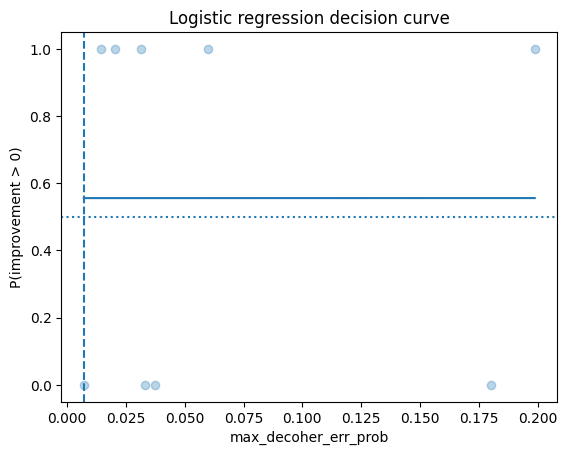

In [45]:
import matplotlib.pyplot as plt 
plt.figure()
plt.scatter(X, y, alpha=0.3)
plt.plot(p, probs)
plt.axvline(threshold_ml, linestyle="--")
plt.axhline(0.5, linestyle=":")

plt.xlabel("max_decoher_err_prob")
plt.ylabel("P(improvement > 0)")
plt.title("Logistic regression decision curve")
plt.show()

In [54]:
estimator_options_nozne = EstimatorOptions(
    dynamical_decoupling={"enable": False},
    twirling={"enable_gates": False, "enable_measure": False},
    resilience_level= 0,
    resilience = {
        "zne_mitigation": False,
        "zne" : {
            "noise_factors": (1, 3, 5),
            "extrapolator": "exponential",
        },
    },
)
estimator_options_zne = EstimatorOptions(
    dynamical_decoupling={"enable": False},
    twirling={"enable_gates": False, "enable_measure": False},
    resilience_level= 2,
    resilience = {
        "zne_mitigation": True,
        "zne" : {
            "amplifier": "gate_folding",
            "noise_factors": (1, 3, 5),
            "extrapolator": "exponential",
        },
    },
)

In [2]:
from adaptive_error_mitigation.mitigation.strategies import calculate_h_zne